Times Series prediction can be seen as a regression problem combined with the chalenge of pattern recongnition. For example, the patterns with the seaonal changes are common with weather, finance, etc. In NLP, the words from previous sentences have influence on the current sentence. RNNs are good choices for these type of problems. 

Here we will do the prediction of airline passengers with single and window of time steps. This is a univariate problem. A lot of materials available on the web. You can check the following examples https://www.kaggle.com/singhalamogh/lstm-regression-on-time-series-data https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

## Data Preparation

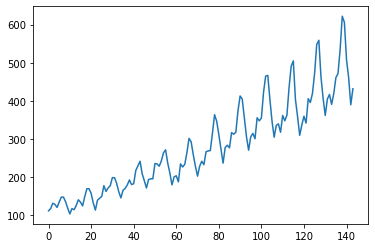

In [1]:
import pandas
import matplotlib.pyplot as plt
dataset = pandas.read_csv('AirPassengers.csv', usecols=[1])
plt.plot(dataset)
plt.show()

In [2]:

import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.metrics import mean_squared_error

In [3]:
# fix random seed for reproducibility
numpy.random.seed(7)

We can also use the code from the previous section to load the dataset as a Pandas dataframe. We can then extract the NumPy array from the dataframe and convert the integer values to floating point values, which are more suitable for modeling with a neural network.


### Normalize dataset

It is a good practice to normalize the input data.  We will use the MinMaxScaler preprocessing class from the scikit-learn library.

In [4]:
# normalize the dataset
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

#### Ordered Split

The order in the sequence is important in a time series. We will keep the order intact while splitting the dataset. Here we do an ordered split of 70:30. 

In [5]:



# split into train and test sets
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))




100 44


#### Reshape the data for LSTM Layer - [samples, time steps, features]

In time series prediction, the past values are used to predict the future values. This means that the past values serve as a feature vector in predicting the future values. In case of an univariate time series, like the one we do here, the univariate values serve as X and Y with different time stamps.

$X = Y(t-1),\ and\  Y = Y(t)$ with a look back value of 1

$X1 = Y(t-1),\  X2 = Y(t-2),\ X3 = Y(t-3),\ and\  Y = Y(t)$ with a look_back value of 3

$X1 = Y(t-1),\ X2 = Y(t-2),\ X3 = Y(t-3),\ X4 = Y(t-4),\ and\  Y = Y(t)$ with a look_back value of 4 

and so on. 

Lets first do look_back = 1. 

In [6]:

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [7]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

(100, 1) (98, 1) (98,)
train=  [0.01544402 0.02702703 0.05405405 0.04826255 0.03281853]
trainX=  [0.01544402 0.02702703 0.05405405 0.04826255 0.03281853]
trainY=  [0.02702703 0.05405405 0.04826255 0.03281853 0.05984556]


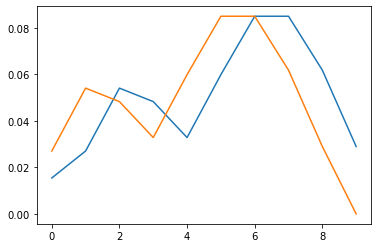

In [8]:
print(train.shape,trainX.shape, trainY.shape)
print("train= ", train[0:5, 0])
print("trainX= ", trainX[0:5, 0])
print("trainY= ", trainY[0:5])
#plt.plot(train[0:10])
plt.plot(trainX[0:10])
plt.plot(trainY[0:10])
#plt.plot(testY)

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].

Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [9]:

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(train.shape,trainX.shape, trainY.shape)

(100, 1) (98, 1, 1) (98,)


## LSTM Model

In [10]:

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(32, input_dim=(look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [11]:
history=model.fit(trainX, trainY, epochs=100, batch_size=1, validation_data=(testX, testY), verbose=2, shuffle=False)

Epoch 1/100
98/98 - 1s - loss: 0.0056 - val_loss: 0.0332
Epoch 2/100
98/98 - 0s - loss: 0.0176 - val_loss: 0.0339
Epoch 3/100
98/98 - 0s - loss: 0.0114 - val_loss: 0.0221
Epoch 4/100
98/98 - 0s - loss: 0.0080 - val_loss: 0.0142
Epoch 5/100
98/98 - 0s - loss: 0.0056 - val_loss: 0.0104
Epoch 6/100
98/98 - 0s - loss: 0.0040 - val_loss: 0.0091
Epoch 7/100
98/98 - 0s - loss: 0.0031 - val_loss: 0.0090
Epoch 8/100
98/98 - 0s - loss: 0.0026 - val_loss: 0.0091
Epoch 9/100
98/98 - 0s - loss: 0.0024 - val_loss: 0.0092
Epoch 10/100
98/98 - 0s - loss: 0.0023 - val_loss: 0.0093
Epoch 11/100
98/98 - 0s - loss: 0.0022 - val_loss: 0.0093
Epoch 12/100
98/98 - 0s - loss: 0.0022 - val_loss: 0.0093
Epoch 13/100
98/98 - 0s - loss: 0.0022 - val_loss: 0.0093
Epoch 14/100
98/98 - 0s - loss: 0.0022 - val_loss: 0.0093
Epoch 15/100
98/98 - 0s - loss: 0.0022 - val_loss: 0.0093
Epoch 16/100
98/98 - 0s - loss: 0.0022 - val_loss: 0.0092
Epoch 17/100
98/98 - 0s - loss: 0.0022 - val_loss: 0.0092
Epoch 18/100
98/98 - 0s

In [12]:
def plot_acc_loss(history):
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')

    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')


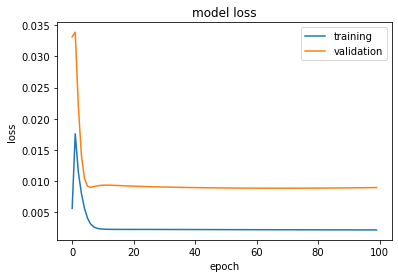

In [13]:
plot_acc_loss(history)

Once the model is fit, we can estimate the performance of the model on the train and test datasets. This will give us a point of comparison for new models.

Note that we invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data (thousands of passengers per month).

In [14]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict_inv = scaler.inverse_transform(trainPredict)
trainY_inv = scaler.inverse_transform([trainY])
testPredict_inv = scaler.inverse_transform(testPredict)
testY_inv = scaler.inverse_transform([testY])


Train Score: 24.24 RMSE
Test Score: 48.93 RMSE


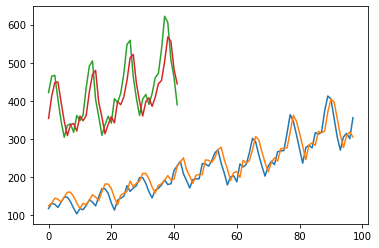

In [15]:
# calculate root mean squared error in terms of actual number
trainScore = math.sqrt(mean_squared_error(trainY_inv[0,:], trainPredict_inv[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_inv[0,:], testPredict_inv[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

plt.plot(trainY_inv[0,:])
plt.plot(trainPredict_inv[:,0])
plt.plot(testY_inv[0,:])
plt.plot(testPredict_inv[:,0])

We need to shift the predictions to align on the x-axis with the original dataset. 


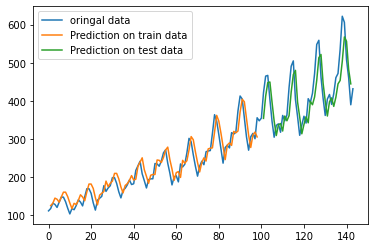

In [16]:

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict_inv)+look_back, :] = trainPredict_inv
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict_inv)+(look_back*2)+1:len(dataset)-1, :] = testPredict_inv
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label='oringal data')
plt.plot(trainPredictPlot, label='Prediction on train data')
plt.plot(testPredictPlot, label='Prediction on test data')
plt.legend(loc="upper left")
plt.show()



### LSTM for Regression Using the Window Method
Lets do the window method and try loop back = 3

In [18]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset

dataframe = read_csv('AirPassengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 128       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 133
Trainable params: 133
Non-trainable params: 0
_________________________________________________________________


In [19]:
history=model.fit(trainX, trainY, epochs=100, batch_size=1, validation_data=(testX, testY), verbose=2, shuffle=False)

Epoch 1/100
96/96 - 1s - loss: 0.0134 - val_loss: 0.0741
Epoch 2/100
96/96 - 0s - loss: 0.0089 - val_loss: 0.0503
Epoch 3/100
96/96 - 0s - loss: 0.0084 - val_loss: 0.0407
Epoch 4/100
96/96 - 0s - loss: 0.0072 - val_loss: 0.0336
Epoch 5/100
96/96 - 0s - loss: 0.0062 - val_loss: 0.0284
Epoch 6/100
96/96 - 0s - loss: 0.0054 - val_loss: 0.0248
Epoch 7/100
96/96 - 0s - loss: 0.0048 - val_loss: 0.0224
Epoch 8/100
96/96 - 0s - loss: 0.0044 - val_loss: 0.0208
Epoch 9/100
96/96 - 0s - loss: 0.0042 - val_loss: 0.0198
Epoch 10/100
96/96 - 0s - loss: 0.0040 - val_loss: 0.0190
Epoch 11/100
96/96 - 0s - loss: 0.0039 - val_loss: 0.0185
Epoch 12/100
96/96 - 0s - loss: 0.0038 - val_loss: 0.0182
Epoch 13/100
96/96 - 0s - loss: 0.0037 - val_loss: 0.0179
Epoch 14/100
96/96 - 0s - loss: 0.0037 - val_loss: 0.0176
Epoch 15/100
96/96 - 0s - loss: 0.0036 - val_loss: 0.0174
Epoch 16/100
96/96 - 0s - loss: 0.0036 - val_loss: 0.0173
Epoch 17/100
96/96 - 0s - loss: 0.0035 - val_loss: 0.0171
Epoch 18/100
96/96 - 0s

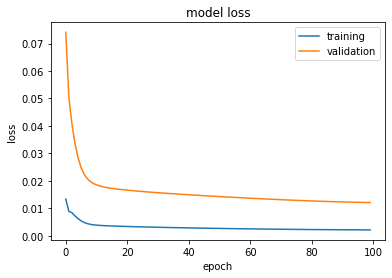

In [20]:
plot_acc_loss(history)

Train Score: 23.68 RMSE
Test Score: 56.98 RMSE


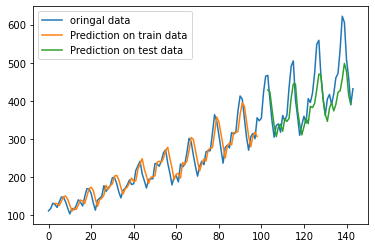

In [21]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label='oringal data')
plt.plot(trainPredictPlot, label='Prediction on train data')
plt.plot(testPredictPlot, label='Prediction on test data')
plt.legend(loc="upper left")
plt.show()